In [1]:
import numpy as np
import random

### Set up plotting

In [2]:
import math
from matplotlib import pyplot as plt

def plots(ims):
    rows = math.ceil(len(ims)/15)
    figsize = (15,1*rows)
    
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, math.ceil(len(ims)/rows), i+1)
        sp.axis('off')
        plt.imshow(ims[i].reshape((28,28)), interpolation='none', cmap='gray_r')

In [3]:
%matplotlib inline

### Load images

In [4]:
from keras import backend as K
from keras.datasets import mnist as mnist_dataset

class MNISTImages:
    def __init__(self):
        img_rows = img_cols = 28
        
        (X_train, y_train), (X_test, y_test) = mnist_dataset.load_data()

        if K.image_dim_ordering() == 'th':
            X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
            X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
            input_shape = (1, img_rows, img_cols)
        else:
            X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
            X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)
            
        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')
        X_train = X_train/256
        X_test = X_test/256
            
        self.train_input = X_train
        self.train_labels = self.to_categorical(y_train)
        
        self.test_input = X_test
        self.test_labels = self.to_categorical(y_test)
        
    def to_categorical(self,y):
        y = np.array(y, dtype='int').ravel()
        nb_classes = np.max(y) + 1
        n = y.shape[0]
        categorical = np.zeros((n, nb_classes))
        categorical[np.arange(n), y] = 1
        return categorical
    
mnist = MNISTImages()

Using TensorFlow backend.


### Set up networks

In [21]:
from keras.models import Model
from keras.optimizers import Nadam
from keras.layers.normalization import BatchNormalization
from keras.layers import Input
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Dropout, Activation, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, Conv2DTranspose, UpSampling2D

gen_mul = 20

g_input = Input(shape=(100,))
g = Dense(7*7*gen_mul*4, input_shape=(100,), kernel_initializer='glorot_normal')(g_input)
g = BatchNormalization()(g)
g = LeakyReLU(0.2)(g)
g = Reshape( [7, 7, gen_mul*4] )(g)
g = Conv2D(gen_mul*2, (5, 5), padding="same", kernel_initializer='glorot_uniform')(g)
g = BatchNormalization(axis=3)(g)
g = LeakyReLU(0.2)(g)
g = UpSampling2D(size=(2, 2))(g)
g = Conv2D(gen_mul*2, (7, 7), padding="same", kernel_initializer='glorot_uniform')(g)
g = BatchNormalization(axis=3)(g)
g = LeakyReLU(0.2)(g)
#g = Conv2DTranspose(gen_mul, (5, 5),padding="same", strides=(2, 2))(g)
g = UpSampling2D(size=(2, 2))(g)
g = Conv2D(gen_mul, (7, 7), padding="same", kernel_initializer='glorot_uniform')(g)
g = BatchNormalization(axis=3)(g)
g = LeakyReLU(0.2)(g)
g_output = Conv2D(1, (7, 7), activation="sigmoid", padding="same", kernel_initializer='glorot_uniform')(g)

disc_mul = 30

d_input = Input(shape=(28,28,1))
d = BatchNormalization(axis=3)(d_input)
d = Conv2D(disc_mul*2, (7, 7), activation="relu", padding="same")(d)
d = Conv2D(disc_mul*2, (5, 5), activation="relu", padding="same", strides=(2,2))(d)
d = BatchNormalization(axis=3)(d)
d = Dropout(0.1)(d)
d = Conv2D(disc_mul, (5, 5), activation="relu", padding="same", strides=(2,2))(d)
d = Dropout(0.2)(d)
d = Flatten()(d)
d = Dense(128, activation='relu')(d)
d = Dropout(0.45)(d)
d = Dense(1)(d)
d_output = Activation('sigmoid')(d)


opt = Nadam(lr=1e-5)
dopt = Nadam(lr=1e-5)

generator = Model(g_input,g_output)
generator.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

discriminator = Model(d_input,d_output)
discriminator.compile(optimizer=dopt, loss='binary_crossentropy', metrics=['accuracy'])

gan_input = Input(shape=(100,))
gan_output = discriminator(generator(gan_input))
GAN = Model(gan_input, gan_output)
GAN.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

### Let's see what the generator does by default

In [6]:
def get_random_input_for_generator(n,div=1):
    return np.random.normal(0, div, (n,100))

In [9]:
def get_generator_samples(n=15, div=1):
    plots(generator.predict(get_random_input_for_generator(n,div)))

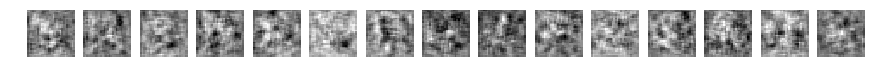

In [10]:
get_generator_samples()

### Train gan

In [11]:
replay_images = []

In [22]:
from IPython import display

noise_level = 0

def plot_loss(losses):
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.yscale('log')
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()

def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val


def real_batch(batch_size):
    return mnist.train_input[np.random.randint(0,mnist.train_input.shape[0],size=batch_size),:,:,:]
    
def fake_batch(batch_size):
    return np.array(generator.predict(get_random_input_for_generator(batch_size)))

def replay_batch(batch_size):
    return np.array([replay_images[np.random.randint(0,len(replay_images))] for i in range(batch_size)])

def add_to_replay_images():
    replay_images.append(generator.predict(get_random_input_for_generator(1))[0])
    
def combined_discriminator_training_batch(fake_batch_size, replay_batch_size, real_batch_size):
    return np.concatenate((
        fake_batch(fake_batch_size), 
        replay_batch(replay_batch_size),
        real_batch(real_batch_size)
    ))
    
def label_noise_level(i):
    return pow(0.5, 1+i/1500)

def noisy_labels(zeros_size, ones_size):
    return np.concatenate((
        np.random.uniform(0, noise_level, zeros_size),
        np.random.uniform(1 - noise_level, 1, ones_size)
    ))

def train_discriminator_on_batch(training_images, training_labels):
    make_trainable(discriminator,True)
    return discriminator.train_on_batch(
        training_images, 
        training_labels
    )    
    

def train_discriminator_separately(batch_size):
    loss1 = train_discriminator_on_batch(
        fake_batch(batch_size),
        noisy_labels(batch_size, 0)
    )
    
    loss2 = train_discriminator_on_batch(
        real_batch(batch_size),
        noisy_labels(0, batch_size)
    )
    
    loss3 = train_discriminator_on_batch(
        replay_batch(batch_size),
        noisy_labels(batch_size, 0)
    )
    
    loss4 = train_discriminator_on_batch(
        real_batch(batch_size),
        noisy_labels(0, batch_size)
    )
    
    return [
        (loss1[0] + loss2[0] + loss3[0] + loss4[0])/4,
        (loss1[1] + loss2[1] + loss3[1] + loss4[1])/4
    ]
    
    
def train_discriminator_combined(batch_size):    
    return train_discriminator_on_batch(
        combined_discriminator_training_batch(batch_size, batch_size, 2*batch_size),
        noisy_labels(2*batch_size, 2*batch_size)
    )
        
def train_generator(batch_size):
    prior_x = np.array(get_random_input_for_generator(2*batch_size))
    prior_labels = np.array([1]*(2*batch_size))

    make_trainable(discriminator,False)
    return GAN.train_on_batch(prior_x, prior_labels)
        
def train_gan(epochs=5000, batch_size=32):
    losses = {"d":[], "g":[]}
    preview_inputs = get_random_input_for_generator(15)
        
    last_d_loss = 0
    last_g_loss = 0
        
    for i in range(epochs):
        if i%1500 == 0:
            lr = pow(10, -(5+i/1500))
            opt.lr = lr
            dopt.lr = lr
        
        #noise_level = label_noise_level(i)
        
        d_loss = train_discriminator_separately(batch_size)
        #d_loss = train_discriminator_combined(batch_size)
        
        g_loss = train_generator(4*batch_size)
        
        losses['d'].append(d_loss[0])
        losses['g'].append(g_loss[0])
        
        last_d_loss = d_loss[0]
        last_g_loss = g_loss[0]
        
        add_to_replay_images()
        
        if i%100 == 0:
            display.clear_output(wait=True)
            plots(generator.predict(preview_inputs))
            plot_loss(losses)
            print(i, d_loss[0], g_loss[0], d_loss[1], g_loss[1], lr)

In [13]:
for i in range(32):
    add_to_replay_images()

In [23]:
noise_level = 0.01

Pretrain discriminator and generator

In [24]:
for i in range(300):
    d_loss = train_discriminator_separately(32)
    
    if i%5 == 0:
        display.clear_output(wait=True)
        print(i, d_loss[0], d_loss[1])

295 0.0554183796048 0.0


In [25]:
for i in range(50):
    g_loss = train_generator(32)
    
    if i%5 == 0:
        display.clear_output(wait=True)
        print(i, g_loss[0], g_loss[1])

45 0.340626 0.828125


Co-train them

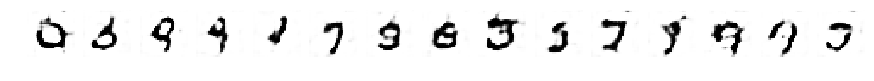

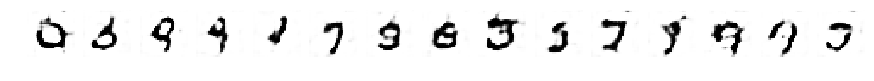

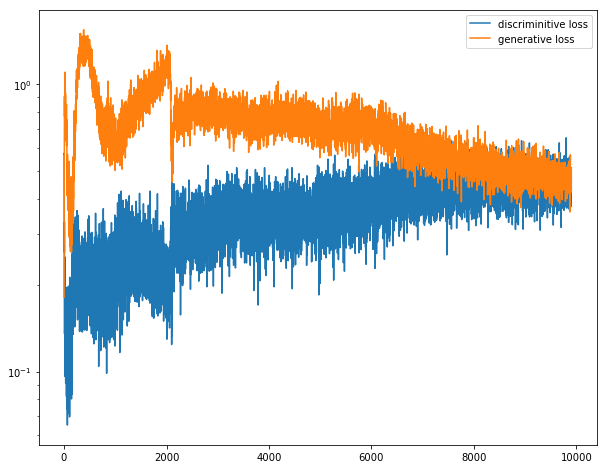

9900 0.433093607426 0.512069 0.0 0.765625 1e-11


In [26]:
train_gan(epochs=10000, batch_size=16)

### Examine results

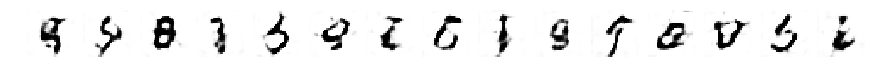

In [27]:
get_generator_samples()

In [28]:
GAN.predict(get_random_input_for_generator(8))

array([[ 0.36938241],
       [ 0.440294  ],
       [ 0.544586  ],
       [ 0.59220093],
       [ 0.69801271],
       [ 0.3742907 ],
       [ 0.27022046],
       [ 0.56663269]], dtype=float32)

In [29]:
discriminator.predict(mnist.train_input[np.random.randint(0,mnist.train_input.shape[0],size=8),:,:,:])

array([[ 0.48718882],
       [ 0.64263767],
       [ 0.25473636],
       [ 0.85755944],
       [ 0.39242682],
       [ 0.42898545],
       [ 0.40843889],
       [ 0.62958223]], dtype=float32)

20033


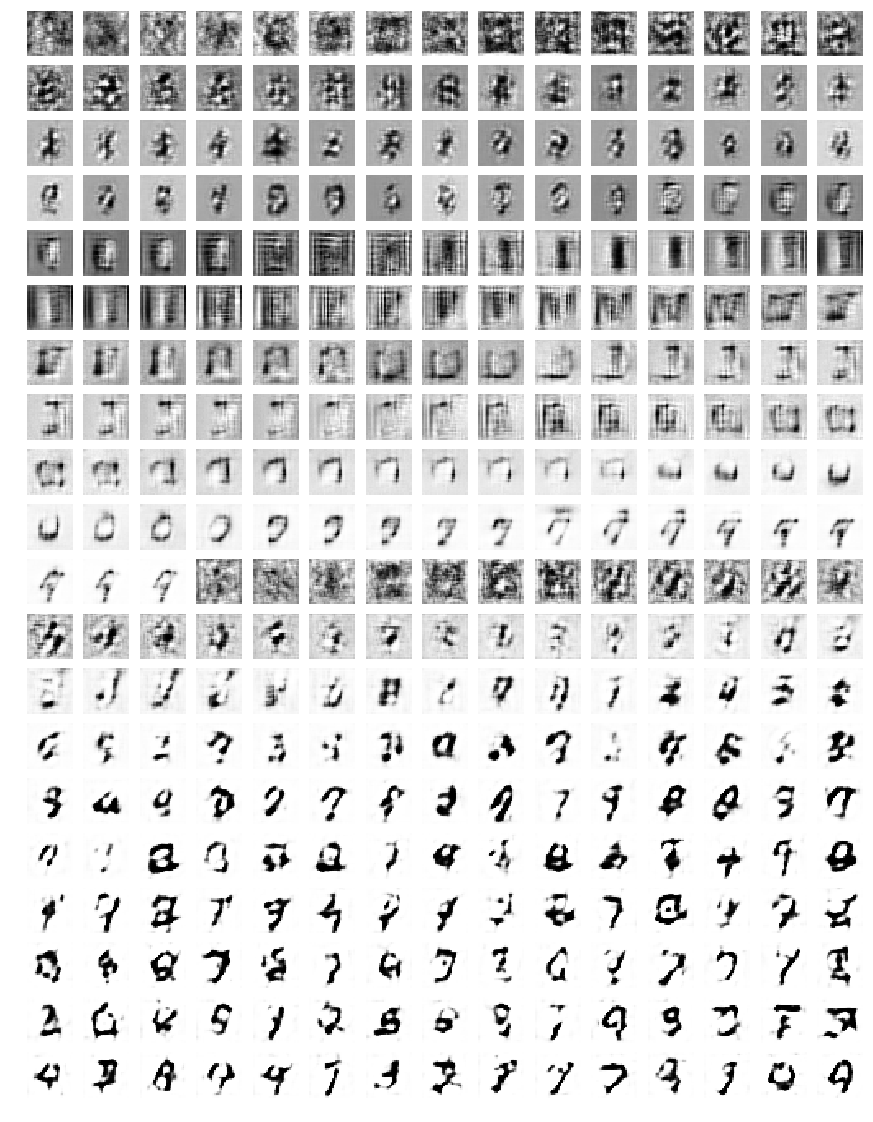

In [31]:
print(len(replay_images))
plots([replay_images[i*math.floor(len(replay_images)/300)] for i in range(300)])

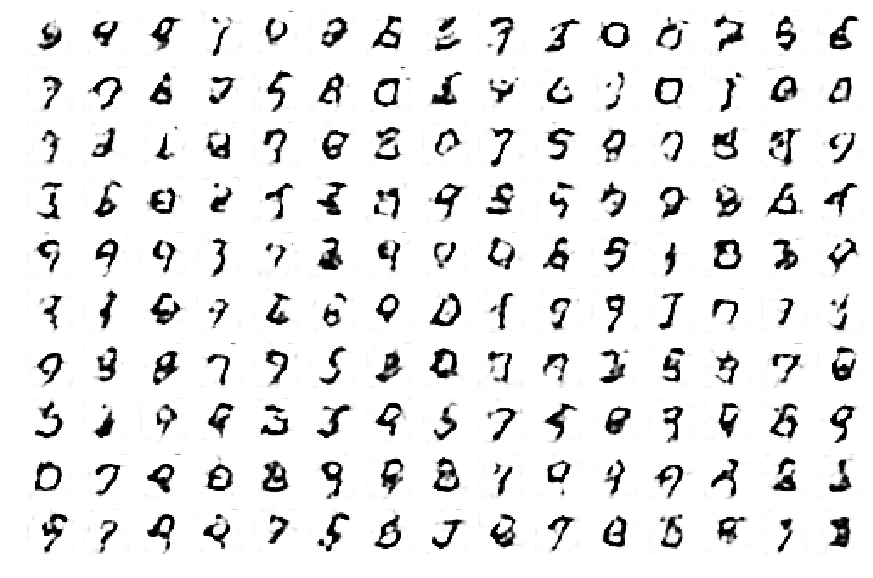

In [32]:
plots(generator.predict(get_random_input_for_generator(150)))

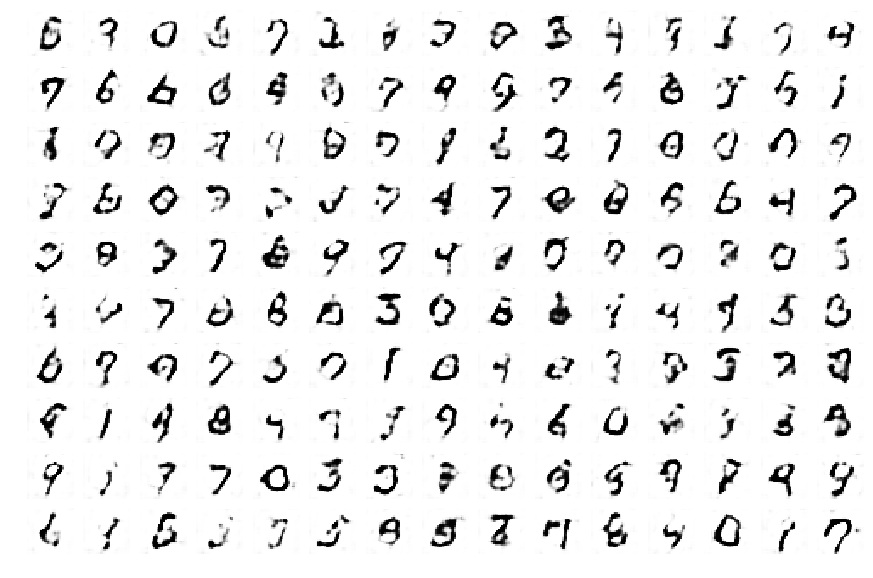

In [34]:
plots(generator.predict(get_random_input_for_generator(150,0.9)))

In [35]:
generator.save_weights('/data/trained_models/mnist/gan/generator_v2.3.h5')
discriminator.save_weights('/data/trained_models/mnist/gan/discriminator_v2.3.h5')

In [ ]:
generator.load_weights('/data/trained_models/mnist/gan/generator_v2.2.h5')
discriminator.load_weights('/data/trained_models/mnist/gan/discriminator_v2.2.h5')